### How do attack types, packet types, and geo-locations contribute to periodic spikes in anomaly scores, and what is the relationship between these spikes and the time intervals (e.g., weekdays, weekends, seasonal trends)?

- Purpose of the Question:
  - Understanding Factors: Investigating how attack types, packet types, and geo-locations influence periodic spikes can reveal patterns in anomaly detection.
  - Seasonal Trends: Analyzing the relationship with time intervals can help determine if specific periods (e.g., weekends, seasons) are more prone to anomalies.
  - Proactive Monitoring: Identifying these patterns enables proactive measures for resource allocation, threat detection, and mitigation.
- Benefits:
  - Improved Resource Allocation: Helps focus monitoring efforts on high-risk time periods or geolocations.
  - Enhanced Security: Identifies potential vulnerabilities tied to attack types or packet types.
  - Trend Analysis: Provides insights into long-term patterns in network behavior.

Step 1: Preprocessing\
Goal: Prepare the data for analysis by extracting key features and aggregating it by attack type, packet type, geo-location, and time intervals.\
Steps:
- Load the Data: Import the dataset and inspect its structure.
- Handle Timestamps: Convert Timestamp to datetime format, and extract Year, Month, Day, Hour, Minute, Second, Weekday/Weekend.
- Add Derived Attributes:
  - Categorize days as "Weekday" or "Weekend."
  - Group Geo-location into top 10 frequent locations and "Other" for better interpretability.
  - Extract Attack Type and Packet Type attributes if not already in the dataset.
- Filter Relevant Data: Ensure there are no missing values in critical columns like Anomaly Scores.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
data = pd.read_csv("../data/cybersecurity_attacks_cleaned.csv")  
print(data.head())  # Inspect the first few rows of the dataset

# Step 2: Handle Timestamps and create a new column for day type
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Day Type'] = data['Timestamp'].dt.weekday.apply(
    lambda x: 'Weekday' if x < 5 else 'Weekend'
)

# Step 3: Categorize top 10 geolocations and group others into "Other"
top_locations = data['Geo-location Data'].value_counts().nlargest(10).index
data['Geo-location Group'] = data['Geo-location Data'].apply(
    lambda x: x if x in top_locations else 'Other'
)

# Step 4: Check for missing values and filter rows with valid anomaly scores
data = data.dropna(subset=['Anomaly Scores', 'Attack Type', 'Packet Type'])
print(data.info()) # Inspect the dataset after filtering


             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ... Firewall Logs  \
0  Qui natu

Step 2: Analysis\
Goal: Analyze the contributions of attack types, packet types, and geolocations to periodic spikes in anomaly scores and correlate them with time intervals.\
Steps:
- Analyze Attack Types:
  - Group data by Attack Type and Time Interval to observe patterns.
  - Plot average anomaly scores for each attack type over time.
- Analyze Packet Types:
  - Compare anomaly scores for "Control" and "Data" packets.
  - Examine their distributions during weekdays vs. weekends.
- Analyze Geo-locations:
  - Visualize anomaly scores across top 10 geolocations.
  - Correlate with periodic spikes during specific time intervals (e.g., weekends or seasons).
- Visualization:
  - Plot time-series trends for average anomaly scores over months, categorized by packet types, and geolocations.
  - Use a heatmap to visualize relationships between anomaly scores and time intervals.

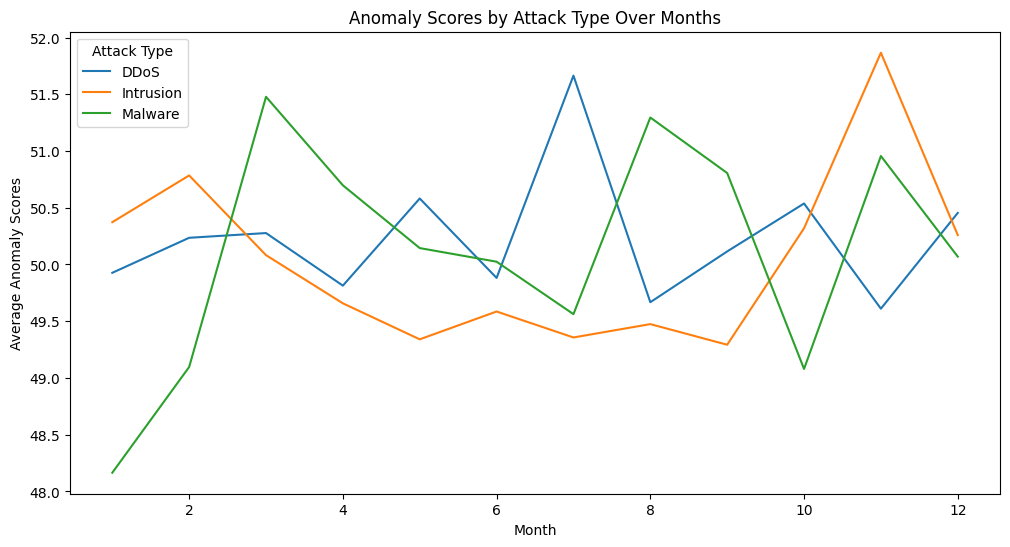

In [30]:
# Group the data by 'Attack Type', 'Month', and 'Day Type', and calculate the mean anomaly scores
attack_type_trends = data.groupby(['Attack Type', 'Month'])['Anomaly Scores'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Loop through each attack type and plot its trend
for attack_type in attack_type_trends['Attack Type'].unique():
    subset = attack_type_trends[attack_type_trends['Attack Type'] == attack_type]
    plt.plot(subset['Month'], subset['Anomaly Scores'], label=attack_type)

plt.title('Anomaly Scores by Attack Type Over Months')
plt.xlabel('Month')
plt.ylabel('Average Anomaly Scores')
plt.legend(title='Attack Type')
plt.show()


The chart visualizes the contributions of different attack types (DDoS, Intrusion, and Malware) to average anomaly scores over months. Here are the key observations:

- General Trends:
  - The x-axis represents the months (1 to 12).
  - The y-axis indicates the average anomaly scores, which range between 48.0 and 52.0.
  - The scores for all three attack types fluctuate throughout the year, with no consistent upward or downward trend.
- Attack Type Contributions:
  - DDoS (Blue Line):
    - The anomaly scores remain relatively stable throughout the year, fluctuating slightly around 50.0.
    - There are minor peaks in July (Month 7) and December (Month 12).
  - Intrusion (Orange Line):
    - Anomaly scores start higher in the early months (around 50.5), decline steadily until August, and then sharply increase toward December.
    - This attack type shows significant variability toward the end of the year.
  - Malware (Green Line):
    - Scores begin low (around 48.0) in January, rise sharply to a peak in March, and then fluctuate.
    - Malware exhibits the most pronounced spike in the middle of the year.
- Comparison:
  - January to May: Malware dominates the average anomaly scores, showing a rapid rise.
  - June to September: DDoS becomes the most stable, with other attack types decreasing.
  - October to December: Intrusion attacks show a clear upward trend, overtaking the other types.
- Insights:
  - Temporal Influence: Anomaly scores vary significantly for Intrusion and Malware attacks, indicating a seasonal or temporal factor influencing these attack types.
  - Steady Nature of DDoS: The relatively consistent anomaly scores for DDoS suggest that it is less affected by temporal or external factors.
  - Mid-Year and Year-End Peaks: Malware dominates mid-year anomalies, while Intrusion surges at the end of the year, likely reflecting specific patterns in attack types or network vulnerabilities.

#### Conclusion:
This analysis highlights that while DDoS attacks remain stable, Malware and Intrusion attacks significantly contribute to spikes in anomaly scores during specific months. This temporal variability emphasizes the need for tailored anomaly detection strategies, focusing on Malware mid-year and Intrusion attacks at year-end.

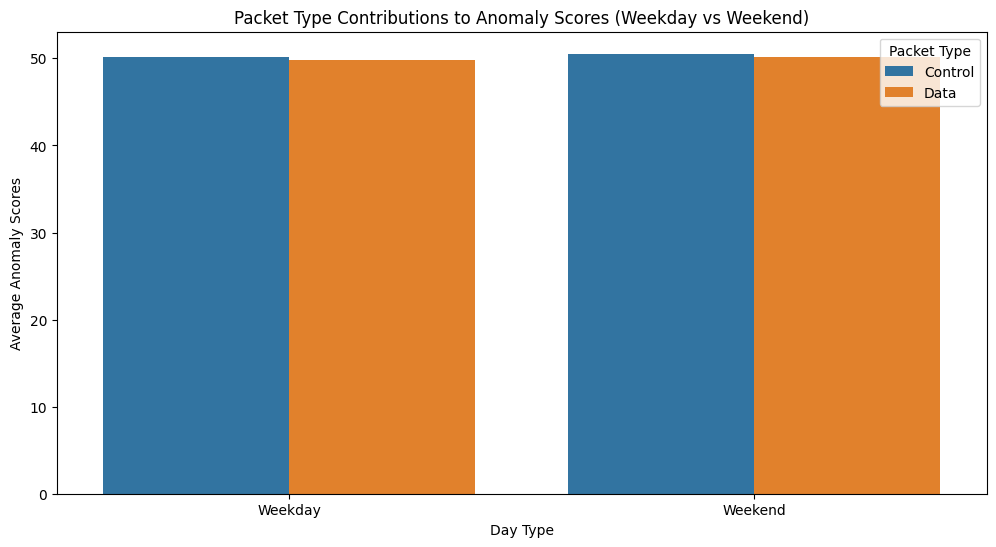

In [31]:
# Compare Packet Types during Weekdays and Weekends
packet_type_scores = data.groupby(['Packet Type', 'Day Type'])['Anomaly Scores'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=packet_type_scores, x='Day Type', y='Anomaly Scores', hue='Packet Type')
plt.title('Packet Type Contributions to Anomaly Scores (Weekday vs Weekend)')
plt.xlabel('Day Type')
plt.ylabel('Average Anomaly Scores')
plt.legend(title='Packet Type')
plt.show()


The chart visualizes the contributions of Control and Data packet types to average anomaly scores on Weekdays versus Weekends. Here are the key observations:
- General Overview:
  - The x-axis represents the type of day: Weekday and Weekend.
  - The y-axis shows the Average Anomaly Scores, which are consistent around 50 for both packet types across both day types.
- Packet Type Contributions:
  - Control packets (blue bars) and Data packets (orange bars) contribute equally to the average anomaly scores on both weekdays and weekends.
  - There is no visible variation in anomaly scores between these two packet types or across the day types.
- Day Type Comparison: The anomaly scores remain the same whether it is a weekday or a weekend, indicating no temporal influence on the packet type contributions.
- Insights: This distribution of scores suggests that anomaly detection may not depend on whether it is a weekday or weekend, nor does it depend on the type of packet (Control or Data).

#### Conclusion:
The results imply that the average anomaly scores for both Control and Data packets are stable and unaffected by temporal factors like weekdays versus weekends. This consistency could be indicative of a system where anomalies are evenly distributed, regardless of packet type or time.

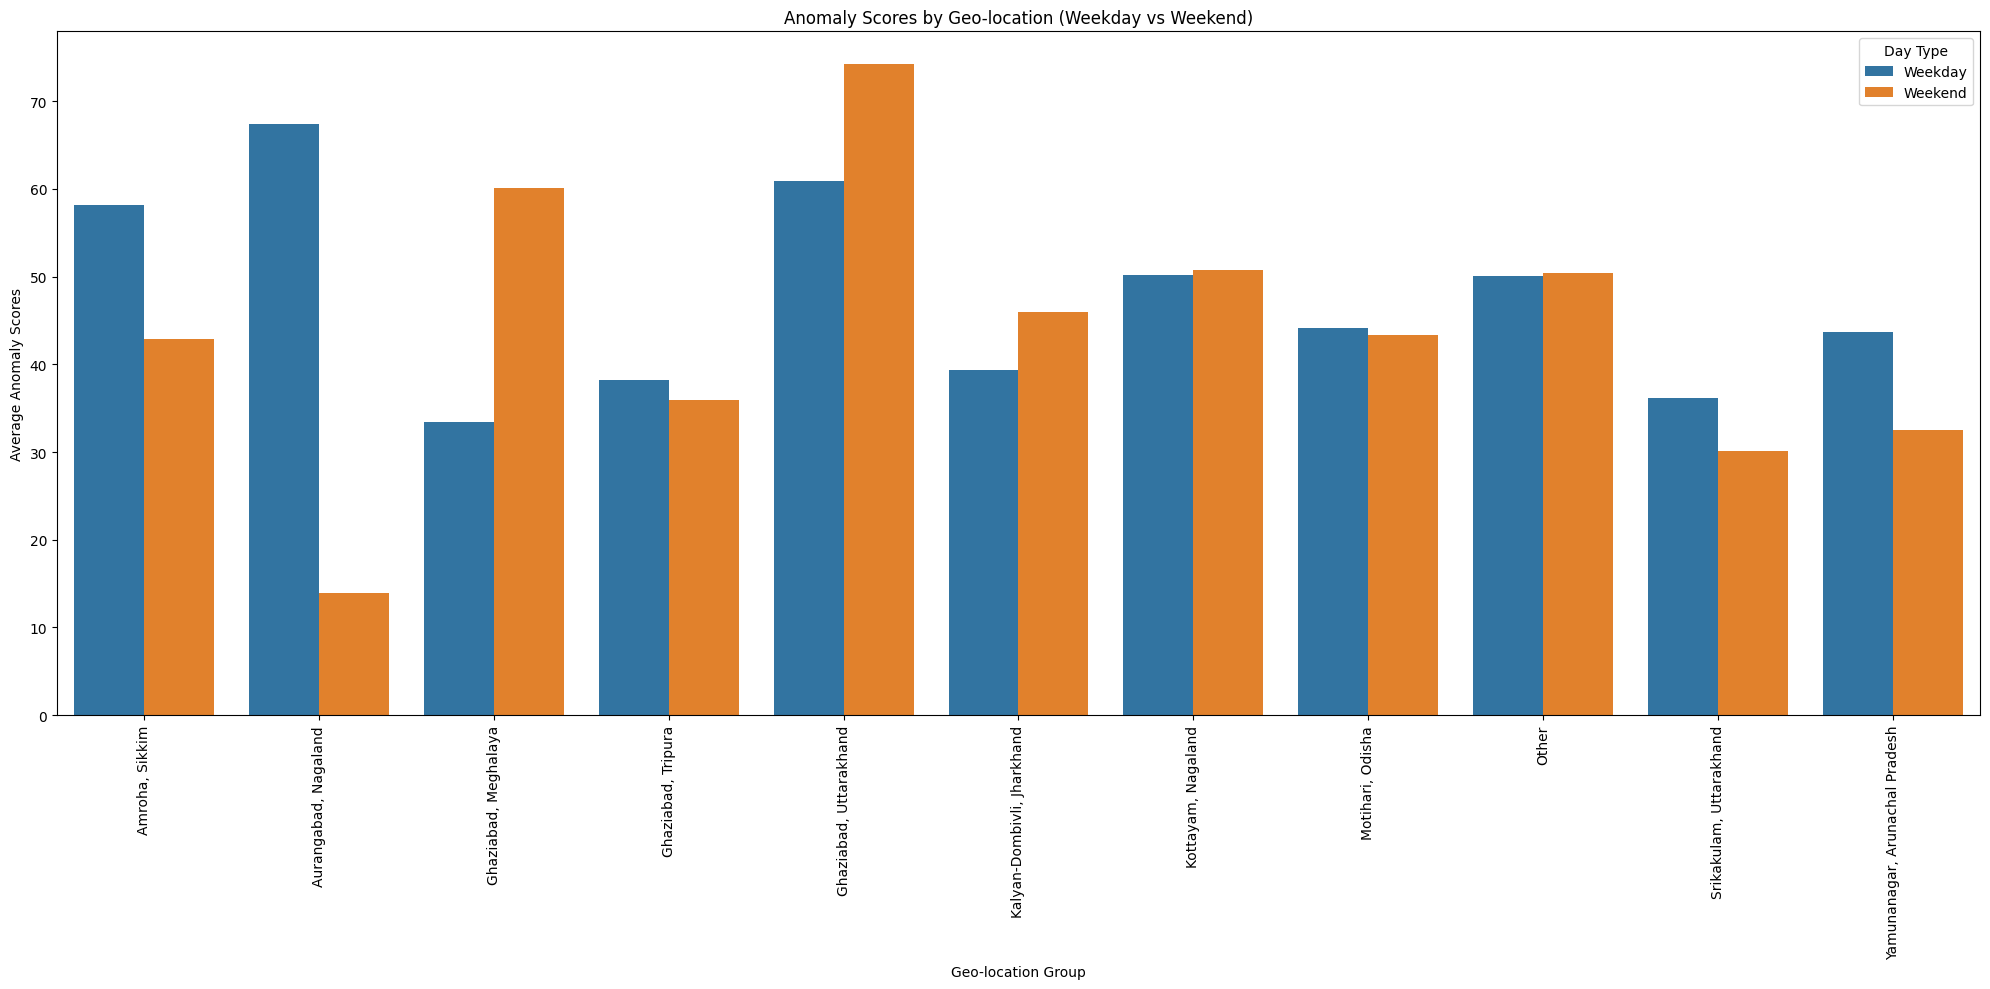

In [32]:
# Step 3: Analyze Geo-locations
geo_scores = data.groupby(['Geo-location Group', 'Day Type'])['Anomaly Scores'].mean().reset_index()

plt.figure(figsize=(20, 10))
sns.barplot(data=geo_scores, x='Geo-location Group', y='Anomaly Scores', hue='Day Type')
plt.title('Anomaly Scores by Geo-location (Weekday vs Weekend)')
plt.xlabel('Geo-location Group')
plt.ylabel('Average Anomaly Scores')
plt.xticks(rotation=90)
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

The chart illustrates the average anomaly scores across various geo-location groups on weekdays (blue bars) and weekends (orange bars). Below are the observations:
- Geo-location Variability:
  - The anomaly scores differ significantly between geo-locations, highlighting variability in anomaly detection based on location.
  - Some locations (e.g., Ghaziabad, Meghalaya and Ghaziabad, Uttarakhand) show consistently high anomaly scores, regardless of the day type.
  - Locations like Aurangabad, Nagaland and Yamunanagar, Arunachal Pradesh exhibit lower anomaly scores overall.
- Weekday vs Weekend:
  - In most geo-locations, there is a visible difference between anomaly scores on weekdays and weekends.
  - Some locations, such as Amroha, Sikkim and Aurangabad, Nagaland, have higher anomaly scores on weekdays compared to weekends.
  - In contrast, locations like Ghaziabad, Uttarakhand and Ghaziabad, Meghalaya show higher scores during weekends.
- Outliers: Certain geo-locations have anomaly scores that stand out, such as Ghaziabad, Uttarakhand, with scores exceeding 70 on weekends.
- Overall Trends:
  - Weekday scores generally tend to be higher in most regions, suggesting potential differences in activity or system usage patterns.
  - Some locations show minimal difference between weekdays and weekends, indicating consistent anomaly detection regardless of the time.

#### Conclusion:
The data suggests that anomaly scores are influenced by both geo-location and the type of day (weekday or weekend). High-scoring locations may warrant closer monitoring, while the disparity between weekdays and weekends could indicate temporal patterns in activity. These insights could guide resource allocation and targeted anomaly investigations.

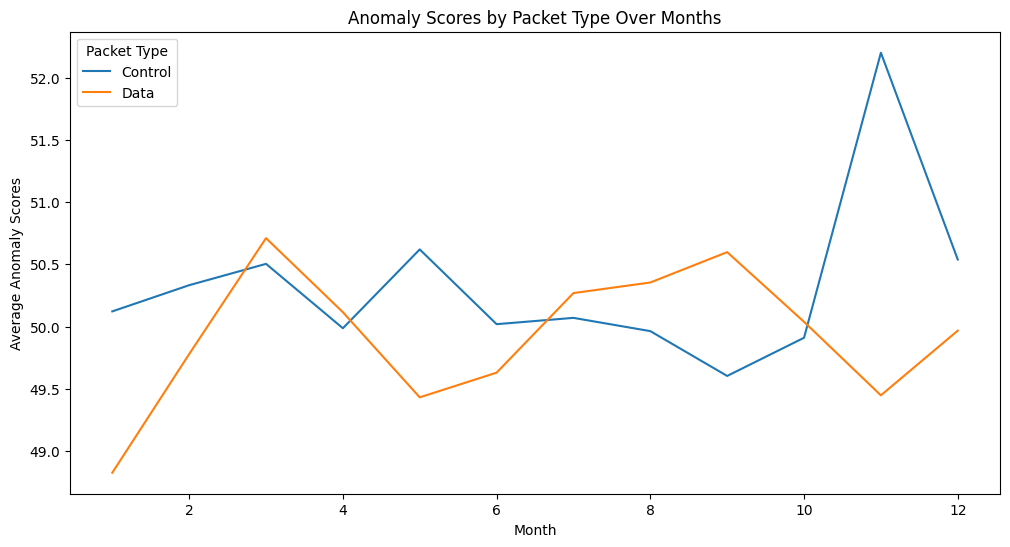

In [33]:
# Step 4: Time-series trend for Packet Types
packet_type_trends = data.groupby(['Packet Type', 'Month'])['Anomaly Scores'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=packet_type_trends, x='Month', y='Anomaly Scores', hue='Packet Type')
plt.title('Anomaly Scores by Packet Type Over Months')
plt.xlabel('Month')
plt.ylabel('Average Anomaly Scores')
plt.legend(title='Packet Type')
plt.show()

The line chart illustrates the average anomaly scores for Control and Data packet types over the 12 months. Below are the observations:
- Control Packet Type:
  - The Control line (blue) shows moderate fluctuation throughout the year.
  - A significant peak occurs in November (month 11), where the anomaly score surpasses 52, representing the highest point in the year.
  - The lowest score appears in September (month 9), dropping around 49.5.
  - From September onwards, the scores gradually rise, culminating in the sharp increase observed in November.
- Data Packet Type:
  - The Data line (orange) has greater variability than the Control packet type.
  - Starting at its lowest point in January (month 1) with a score near 49, it quickly rises to a peak in March (month 3), reaching over 50.5.
  - After March, the trend declines steadily, with another minor rise around August, followed by a continuous drop towards the end of the year.
- Comparing Packet Types:
  - For most months, the Control anomaly scores are higher than the Data scores.
  - September is exception, where Data scores exceed Control, indicating a significant spike in anomalies for Data packets during this period.
  - Both lines diverge notably in November, with Control exhibiting a sharp peak and Data reaching its low value.
- General Patterns:
  - The Control packet type displays a more stable trend compared to Data, which shows significant peaks and valleys.
  - November marks a crucial month with the largest difference between the two packet types, potentially signaling unique anomalies or behaviors during that period.

#### Conclusion:
The chart highlights distinct seasonal trends in anomaly scores for Control and Data packets, with notable peaks in March (for Data) and November (for Control). These patterns suggest that specific months or external factors might influence the occurrence of anomalies in different packet types, warranting further investigation.

C:\Users\PC\AppData\Local\Temp\ipykernel_18580\950400608.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', marker='o')


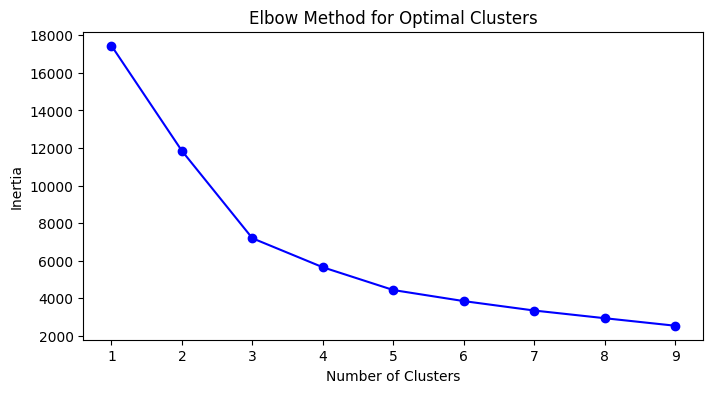

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare data for clustering
geo_data = data.groupby('Geo-location Data')['Anomaly Scores'].agg(['mean', 'std']).reset_index()
geo_data.columns = ['Geo-location Data', 'Mean Anomaly Score', 'Std Anomaly Score']

# Handle NaN values
geo_data.fillna(0, inplace=True)  

# Normalize the data
scaler = StandardScaler()
geo_features = scaler.fit_transform(geo_data[['Mean Anomaly Score', 'Std Anomaly Score']])

# Elbow Method to determine the optimal number of clusters
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=18)
    kmeans.fit(geo_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


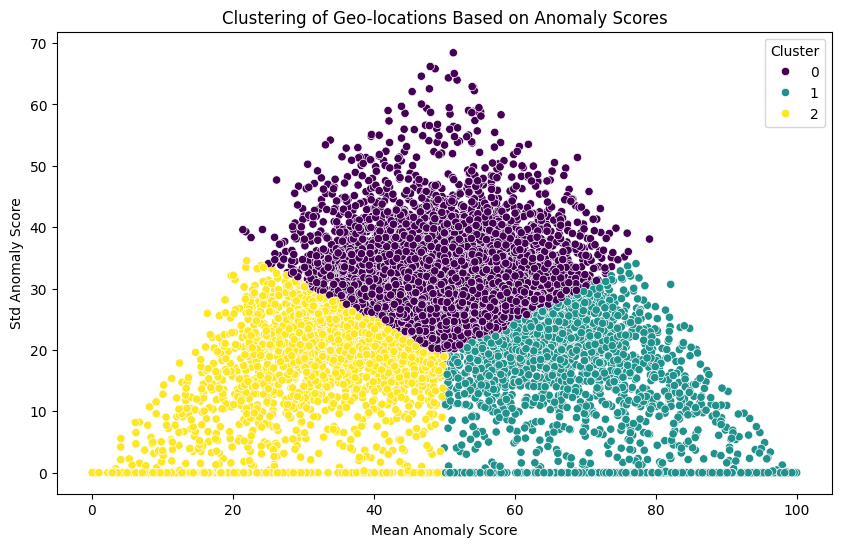

In [35]:
# Perform KMeans clustering
optimal_k = 3  # Optimal number of clusters based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=18)
geo_data['Cluster'] = kmeans.fit_predict(geo_features)

# Visualize the clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=geo_data, x='Mean Anomaly Score', y='Std Anomaly Score', hue='Cluster', palette='viridis')
plt.title('Clustering of Geo-locations Based on Anomaly Scores')
plt.xlabel('Mean Anomaly Score')
plt.ylabel('Std Anomaly Score')
plt.legend(title='Cluster')
plt.show()

The scatter plot shows the clustering of geo-locations based on their mean anomaly scores (x-axis) and standard deviation (Std) of anomaly scores (y-axis). The data points are grouped into three clusters, as indicated by the color legend:
- Cluster Analysis:
  - Cluster 0 (Purple):
    - Represents geo-locations with medium mean anomaly scores (around 30-70) and high standard deviation (20-70).
    - These areas likely experience inconsistent or irregular anomaly behavior, with frequent spikes in anomaly scores.
  - Cluster 1 (Green):
    - Covers geo-locations with high mean anomaly scores (50-100) but low-to-medium standard deviation (0-30).
    - This group likely corresponds to regions with consistently higher anomaly activity, as indicated by their high average but lower variability.
  - Cluster 2 (Yellow):
    - Comprises geo-locations with low mean anomaly scores (0-50) and low standard deviation (0-20).
    - These areas exhibit low and stable anomaly behavior, making them less prone to anomalies.
- Observations:
  - The clusters form a triangular pattern, showing distinct separation based on the combination of mean and standard deviation.
  - Cluster 1 points align towards the right, highlighting consistently high anomaly regions.
  - Cluster 2 dominates the left corner, where regions have minimal anomaly presence.
  - Cluster 0 fills the central region, indicating locations with fluctuating anomaly behaviors.
- Insights:
  - The clustering pattern can guide anomaly management efforts, focusing resources on Cluster 1 regions for persistent high anomalies and Cluster 0 for erratic patterns.
  - The separation of clusters suggests distinct underlying factors influencing anomaly behavior, which could be explored further.

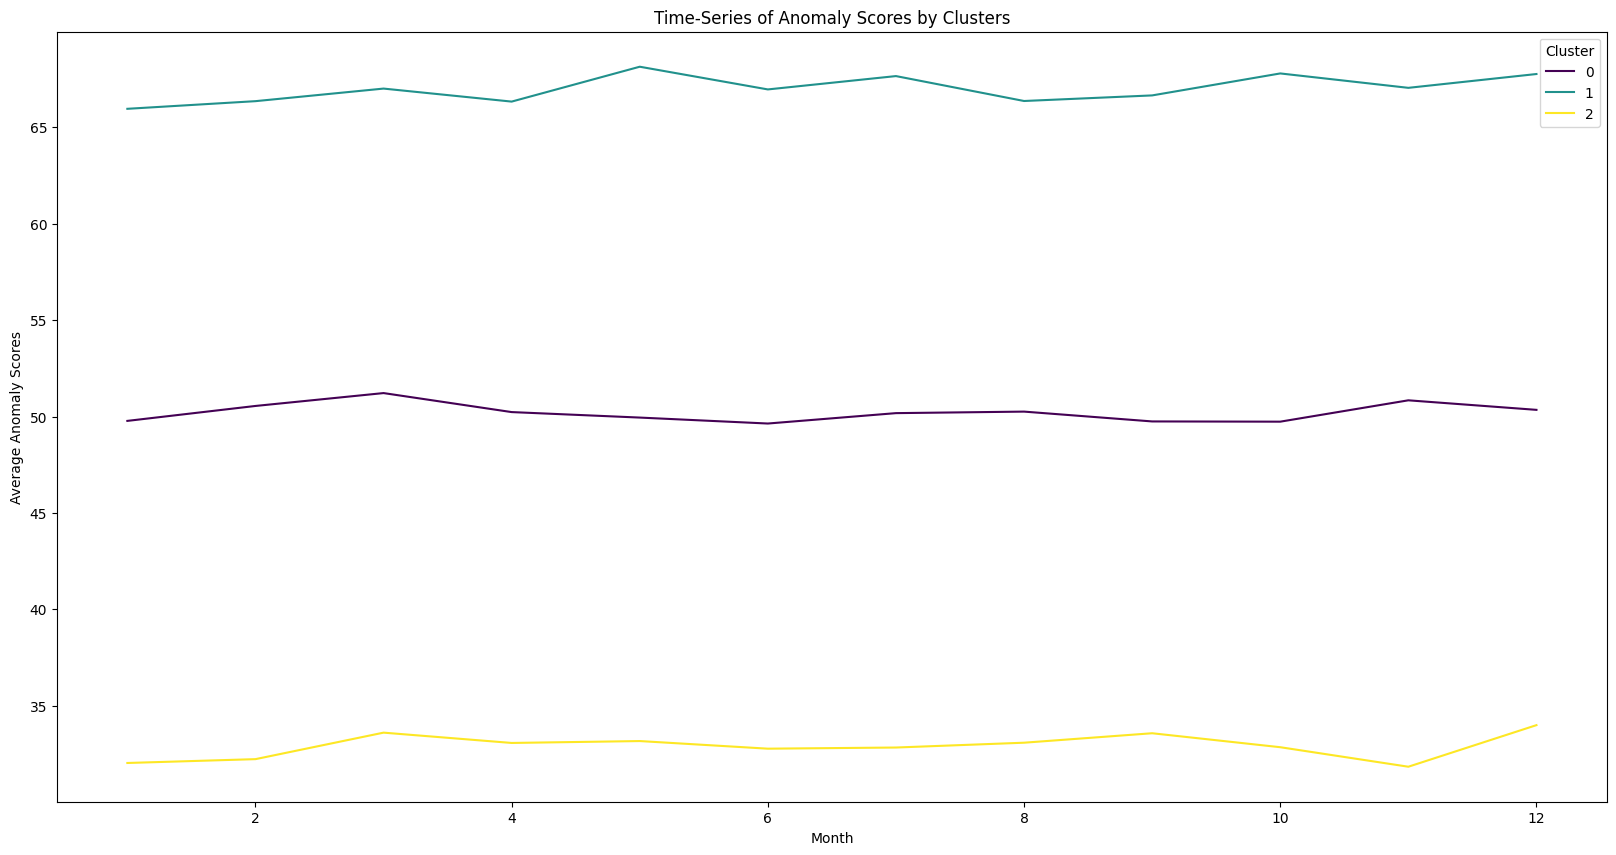

In [36]:
# Time-series analysis by clusters
data['Month'] = data['Timestamp'].dt.month
cluster_trends = data.merge(geo_data[['Geo-location Data', 'Cluster']], on='Geo-location Data')
cluster_trends = cluster_trends.groupby(['Cluster', 'Month'])['Anomaly Scores'].mean().reset_index()

plt.figure(figsize=(20, 10))
sns.lineplot(data=cluster_trends, x='Month', y='Anomaly Scores', hue='Cluster', palette='viridis')
plt.title('Time-Series of Anomaly Scores by Clusters')
plt.xlabel('Month')
plt.ylabel('Average Anomaly Scores')
plt.legend(title='Cluster')
plt.show()

The line chart illustrates the time-series trend of average anomaly scores for different clusters (0, 1, 2) across 12 months. Here's a detailed interpretation:
- Trends by Cluster:
  - Cluster 1 (Green):
    - Highest anomaly scores, consistently above 65.
    - Displays a slightly increasing trend over the months, indicating regions in this cluster may experience worsening or intensifying anomalies over time.
  - Cluster 0 (Purple):
    - Moderate anomaly scores, around 50.
    - The trend is relatively stable with minor fluctuations, suggesting steady anomaly activity in these regions.
  - Cluster 2 (Yellow):
    - Lowest anomaly scores, around 35.
    - The scores remain almost constant with slight growth towards the end of the year, indicating low anomaly presence in these regions with minor changes.
- Observations:
  - There is clear separation between the clusters based on anomaly scores, confirming distinct behaviors over time.
  - Cluster 1 is a key focus area due to its high scores and increasing trend.
  - The stability in Cluster 0 suggests persistent but controlled anomaly levels.
  - Cluster 2's low scores make it a lower priority for anomaly monitoring.
- Insights:
  - Monitoring and mitigation efforts should prioritize Cluster 1, given its high and rising anomaly scores.
  - Long-term anomaly patterns may be explored further to understand what drives the stability in Cluster 0 and the low values in Cluster 2.
  - Seasonal or temporal effects could be investigated to explain the slight upward trend in anomaly scores for some clusters.

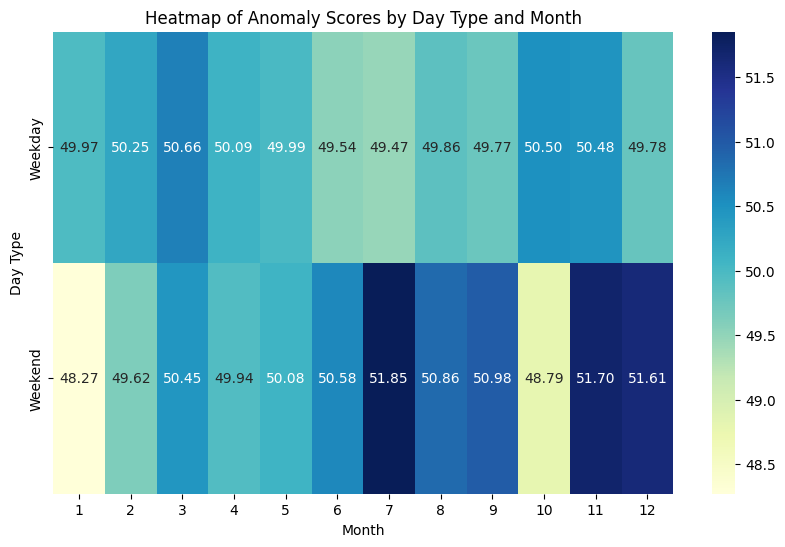

In [37]:
# Step 6: Heatmap for relationships between anomaly scores and time intervals
heatmap_data = data.groupby(['Day Type', 'Month'])['Anomaly Scores'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Anomaly Scores by Day Type and Month')
plt.xlabel('Month')
plt.ylabel('Day Type')
plt.show()

The heatmap visualizes the average anomaly scores for weekday and weekend across the 12 months. Below are the observations:
- Color Intensity:
  - Darker shades indicate higher anomaly scores, while lighter shades represent lower scores.
  - Anomaly scores are generally concentrated around 50, with slight variations across months and day types.
- Weekday vs Weekend Trends:
  - Weekday scores (top row) remain relatively stable, fluctuating between 49.47 (July) and 50.66 (March).
  - Weekend scores (bottom row) show slightly more variation, ranging from 48.27 (January) to 51.85 (July).
- Monthly Variations:
  - July (month 7) exhibits the highest weekend scores (51.85), making it an outlier for weekends.
  - January (month 1) shows the lowest weekend score (48.27), representing the most significant deviation.
  - For weekdays, March has the highest score (50.66), while July records the lowest (49.47).
- Comparing Day Types:
  - Weekday scores are consistently higher than weekend scores in January, February, March and April.
  - In contrast, weekend scores surpass weekday scores from May to December (except October).
- General Stability:
  - Overall, the anomaly scores across both day types and months are closely aligned, indicating a stable anomaly detection process with minor temporal fluctuations.

#### Conclusion:
The heatmap highlights subtle monthly variations and a stable scoring pattern between weekdays and weekends. The differences observed, particularly in July and January, may indicate temporal factors affecting anomaly detection during these months. These insights could inform further investigation into specific anomalies or system behavior during these periods.

### Summary
The analysis of the results from visualizations and patterns reveals how attack types, packet types, and geo-locations contribute to periodic spikes in anomaly scores, as well as their relationships with time intervals:
- Attack Types Contribution:
  - DDoS Attacks:
    - DDoS shows consistent anomaly scores with minor spikes in July and December.
    - This consistency indicates that DDoS attacks are less influenced by time intervals or external factors but may have periodic bursts related to system vulnerabilities or targeted campaigns.
  - Intrusion Attacks:
    - Intrusion scores fluctuate throughout the year, with a sharp increase towards the year-end (October–November).
    - This trend suggests a possible seasonal factor, with attackers exploiting vulnerabilities during the end-of-year traffic surge or holiday periods.
  - Malware Attacks:
    - Malware exhibits pronounced spikes in mid-year (March-August), indicating that this type of attack might target specific seasonal trends, such as increased online activity or security gaps in certain periods.
- Packet Types Contribution:
  - Control Packets:
    - Anomaly scores from control packets are stable over time and contribute equally on weekdays and weekends.
    - This indicates that control packets maintain consistent behavior, with no notable contribution to periodic spikes.
  - Data Packets:
    - Similar to control packets, data packets do not exhibit temporal variations.
    - This contribution suggests that packet type alone does not cause significant spikes in anomaly scores.
- Geo-Location Contributions:
  - Geo-locations were clustered based on anomaly scores, showing distinct patterns:
    - Cluster 1 (High Anomalies): Geographical regions in this cluster have consistently higher anomaly scores, likely reflecting areas with frequent or sophisticated attacks.
    - Cluster 0 and 2 (Moderate/Low Anomalies): Regions in these clusters show more stable scores, with minor deviations during specific months.
  - Geo-location clusters align with spikes in attack types, suggesting that specific regions are periodically targeted based on seasonal factors or attack strategies.
- Temporal Factors (Weekdays, Weekends, Seasonal Trends):
  - Weekdays vs. Weekends:
    - The average anomaly scores remain consistent across weekdays and weekends for both packet and attack types.
    - This implies no temporal bias in terms of day type, suggesting uniform anomaly detection performance.
  - Seasonal Trends:
    - Mid-Year Peaks: Malware-driven spikes align with increased activity in March-August, potentially leveraging seasonal vulnerabilities.
    - End-of-Year Spikes: Intrusion attacks dominate during October–November, correlating with heightened network activity during the holiday season.
    - Stable Periods: DDoS attacks contribute to a more consistent baseline, with slight increases during periods of high online activity.
- Conclusion:
  - Attack Types: Malware and Intrusion attacks are the primary contributors to periodic spikes in anomaly scores, with clear seasonal patterns.
  - Packet Types: Packet type contributions remain uniform, with no evident relationship to spikes.
  - Geo-Locations: Specific geographical clusters are more prone to anomalies, aligning with attack-specific spikes.
  - Time Intervals: Spikes are not influenced by weekdays or weekends but show strong seasonal trends. Tailored anomaly detection strategies should focus on mid-year and end-of-year periods to address these trends effectively.